# Flattened dT analysis
Full combinatorics

In [1]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# Internal modules 
sys.path.extend(["../../src/core", "../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [2]:

!ls -ltrh ../../output/dt/b/data

total 0
drwxr-sr-x  6 sgrant  staff   192B Dec  5 12:32 CRY_onspill-LH_aw
drwxr-sr-x  6 sgrant  staff   192B Dec  5 12:36 CRY_mix2BB_onspill-LH_aw
drwxr-sr-x  6 sgrant  staff   192B Dec  5 12:40 CE_onspill-LH_aw
drwxr-sr-x  6 sgrant  staff   192B Dec  5 12:43 CE_mix2BB_onspill-LH_aw


In [5]:
run = "b"
base_in_path = Path(f"../../output/dt/{run}/data/")

# Load both test datasets
cry_path = base_in_path / "CRY_onspill-LH_aw/"
ce_mix2bb_path = base_in_path / "CE_mix2BB_onspill-LH_aw/"

print(f"Loading CRY data from: {cry_path}")
cry_data = Load(in_path=cry_path).load_pkl()["events"]

print(f"Loading CE Mix2BB data from: {ce_mix2bb_path}")
ce_mix_data = Load(in_path=ce_mix2bb_path).load_pkl()["events"]

print(f"CRY events: {len(cry_data)}")
print(f"CE mix2BB events: {len(ce_mix_data)}")

Loading CRY data from: ../../output/dt/b/data/CRY_onspill-LH_aw
[Load] ✅ Initialised with out_path=../../output/dt/b/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/dt/b/data/CRY_onspill-LH_aw/results.pkl
Loading CE Mix2BB data from: ../../output/dt/b/data/CE_mix2BB_onspill-LH_aw
[Load] ✅ Initialised with out_path=../../output/dt/b/data/CE_mix2BB_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/dt/b/data/CE_mix2BB_onspill-LH_aw/results.pkl
CRY events: 23727
CE mix2BB events: 2139827


## Add duration  (could also do this in processing)

In [6]:
## Add duration
cry_data["duration"] = cry_data["timeEnd"] - cry_data["timeStart"]
ce_mix_data["duration"] = ce_mix_data["timeEnd"] - ce_mix_data["timeStart"]

## Convert to DataFrame

In [7]:
# Convert awkward arrays to DataFrame
df_cry = ak.to_dataframe(cry_data)
df_ce_mix = ak.to_dataframe(ce_mix_data)

## Add central dT (could also do this in processing)

In [60]:
def get_cent_dT(df, dt_min=-25, dt_max=150):
    """
    Get the dT value closest to the window center for each event.
    """
    window_center = (dt_min + dt_max) / 2
    df = df.copy(deep=True)  # Avoid modifying original dataframe
    df['dist_to_centre'] = np.abs(df['dT'] - window_center)
    
    # Get the central dT for each event
    central_dt_per_event = df.loc[df.groupby(['event', 'subrun'])['dist_to_centre'].idxmin()][['event', 'subrun', 'dT']]
    central_dt_per_event = central_dt_per_event.rename(columns={'dT': 'cent_dT'})
    
    # Merge back to add as column
    df = df.merge(central_dt_per_event, on=['event', 'subrun'], how='left')
    df = df.drop(columns=['dist_to_centre'])
    
    return df

df_cry = get_cent_dT(df_cry)
df_ce_mix = get_cent_dT(df_ce_mix)


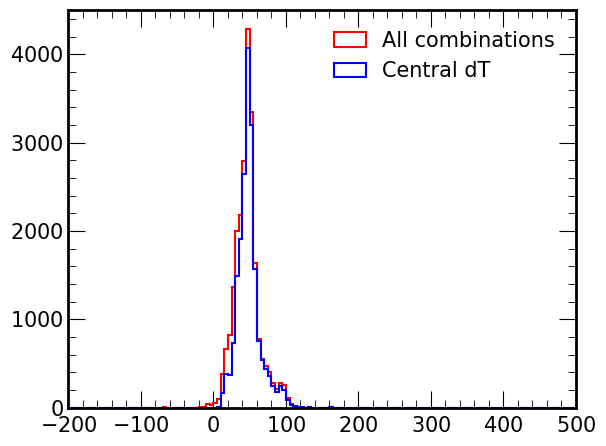

In [65]:
plotter.plot_1D_overlay(
    {
        "All combinations" : df_cry["dT"], 
        "Central dT" :  df_cry.drop_duplicates(subset=['event', 'subrun'])["cent_dT"],
    },
    nbins=140,
    xmin=-200,
    xmax=500 
    
)

In [11]:
df_cry.head()
df_ce_mix.head()

,event,subrun,run,dT,crv_x,crv_y,crv_z,PEs,nHits,nLayers,...,crv_time,sector,PEs_per_hit,t0,d0,tanDip,maxr,mom_mag,duration,cent_dt
0,23.0,46.0,1210.0,851.097202,4317.791992,2873.401855,-9957.799805,1432.558228,65.0,4.0,...,588.474487,4.0,22.039357,1439.571690,64.233398,0.939247,553.678711,104.528412,700.000031,17.841343
1,23.0,46.0,1210.0,17.841343,4168.450195,2891.504395,-9957.799805,238.057526,13.0,4.0,...,1421.730347,4.0,18.312117,1439.571690,64.233398,0.939247,553.678711,104.528412,362.500000,17.841343
2,23.0,46.0,1210.0,-147.009609,636.200012,1169.587524,-12563.380859,187.563354,12.0,4.0,...,1586.581299,5.0,15.630280,1439.571690,64.233398,0.939247,553.678711,104.528412,412.500000,17.841343
3,30.0,46.0,1210.0,-428.267026,-2587.561523,275.529999,-4173.916016,26.419159,3.0,3.0,...,1182.653442,1.0,8.806386,754.386416,33.225609,0.831509,483.464691,104.191429,75.000000,-280.247251
4,30.0,46.0,1210.0,-622.537778,2556.410156,800.816956,-5141.687500,251.457169,12.0,3.0,...,1376.924194,2.0,20.954764,754.386416,33.225609,0.831509,483.464691,104.191429,125.000000,-280.247251




## Convert to DataFrames

## Develop time start/end cut 

reoptimisation for MDC2020aw

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../output/images/dt/b/h1_2x2_start_end_time.png


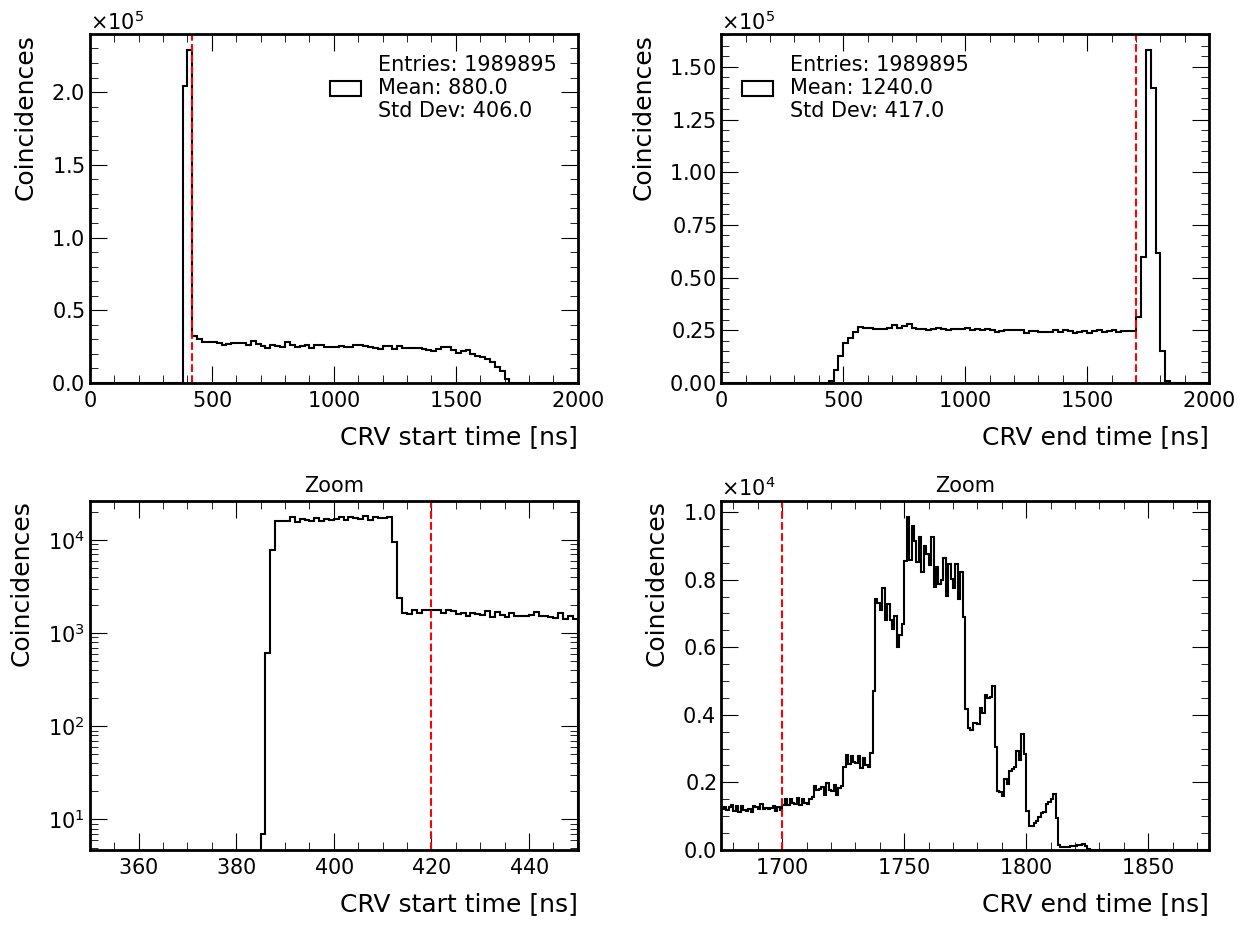

In [12]:
from pyutils.pyplot import Plot 

plotter = Plot()
fig, ax = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))

plotter.plot_1D(
    df_ce_mix["timeStart"],
    nbins=100,  
    xmin=0,
    xmax=2000,
    show=False,
    ax=ax[0,0],
    # title="CE Mix2BB MDC2020aw",
    xlabel="CRV start time [ns]", 
    ylabel="Coincidences",
    norm_by_area=False     
)

plotter.plot_1D(
    df_ce_mix["timeEnd"],
    nbins=100,  
    xmin=0,
    xmax=2000,
    show=False,
    ax=ax[0,1],
    # title="CE Mix2BB MDC2020aw",
    xlabel="CRV end time [ns]", 
    ylabel="Coincidences",
    norm_by_area=False,
   
)

plotter.plot_1D(
    df_ce_mix["timeStart"],
    nbins=100,  
    xmin=350,
    xmax=450,
    show=False,
    ax=ax[1,0],
    log_y=True,
    title="Zoom",
    xlabel="CRV start time [ns]", 
    ylabel="Coincidences",
    norm_by_area=False,
    stat_box=False   
)

plotter.plot_1D(
    df_ce_mix["timeEnd"],
    nbins=200,  
    xmin=1675,
    xmax=1875,
    show=False,
    ax=ax[1,1],
    # log_y=True,
    title="Zoom",
    xlabel="CRV end time [ns]", 
    ylabel="Coincidences",
    norm_by_area=False,
    stat_box=False     
)

ax[0,0].axvline(420, linestyle="--")
ax[0,1].axvline(1700, linestyle="--")

ax[1,0].axvline(420, linestyle="--")
ax[1,1].axvline(1700, linestyle="--")


plt.tight_layout()
img_base_path = Path(f"../../output/images/dt/{run}/")
img_base_path.mkdir(exist_ok=True, parents=True)
out_name = img_base_path / "h1_2x2_start_end_time.png" 
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()

	Wrote ../../output/images/dt/b/h1o_1x2_start_end_time_cut.png


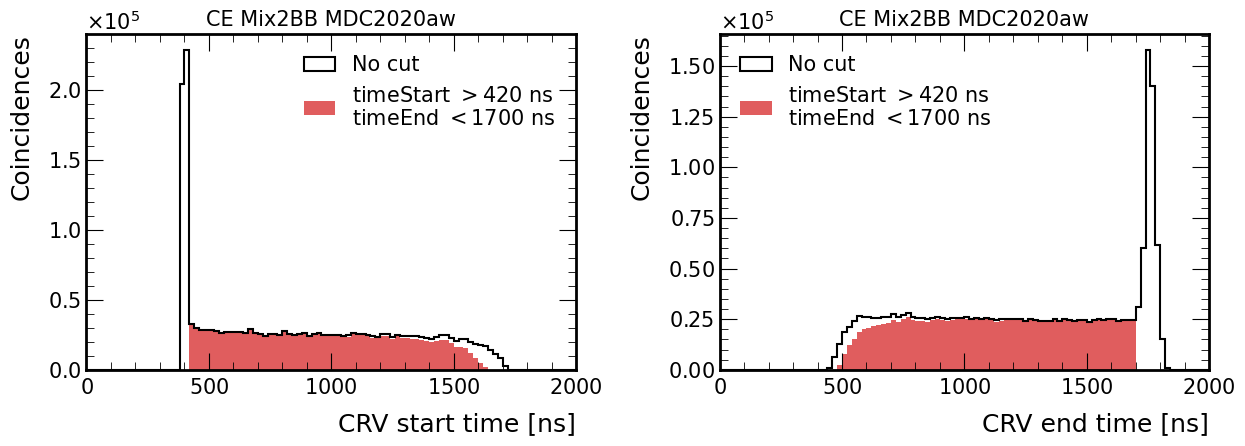

In [14]:
# Apply cut 
ce_mix_condition = ((df_ce_mix["timeStart"] > 420) & (df_ce_mix["timeEnd"] < 1700))

fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 1*4.8))

styles = {
    "No cut" : {
        "color": "black",
        "linestyle": "-"
    },
    "timeStart $>420$ ns\ntimeEnd $<1700$ ns" : {
        "color": "red",
        "histtype": "stepfilled",
        "alpha": 0.75
    },  

}

styles = {
    "No cut": {
        "color": "black",
        "linestyle": "-",
        "linewidth": 1.5,  # Make baseline more visible
        "zorder": 3  # Draw on top
    },
    "timeStart $>420$ ns\ntimeEnd $<1700$ ns": {
        "color": "#d62728",  # Slightly better red
        "histtype": "stepfilled",
        "alpha": 0.75,  # Slightly more transparent
        "edgecolor": "darkred",  # Add edge for definition
        "linewidth": 1.0,
        "zorder": 2
    },  
}

plotter.plot_1D_overlay(
    {
        "No cut" : df_ce_mix["timeStart"],
        "timeStart $>420$ ns\ntimeEnd $<1700$ ns" : df_ce_mix["timeStart"][ce_mix_condition]
    },
    nbins=100,  
    xmin=0,
    xmax=2000,
    show=False,
    ax=ax[0],
    styles=styles,
    title="CE Mix2BB MDC2020aw",
    xlabel="CRV start time [ns]", 
    ylabel="Coincidences",
    norm_by_area=False     
)

plotter.plot_1D_overlay(
    {
        "No cut" : df_ce_mix["timeEnd"],
        "timeStart $>420$ ns\ntimeEnd $<1700$ ns" : df_ce_mix["timeEnd"][ce_mix_condition]
    },
    nbins=100,  
    xmin=0,
    xmax=2000,
    show=False,
    ax=ax[1],
    styles=styles,
    title="CE Mix2BB MDC2020aw",
    xlabel="CRV end time [ns]", 
    ylabel="Coincidences",
)

plt.tight_layout()

out_name = img_base_path / "h1o_1x2_start_end_time_cut.png" 
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()

In [ ]:
def get_start_end_cut_impact(df, metric, start_end_window=(420, 1700), dt_window=(-25, 150)):
    """
    Calculate deadtime or efficiency before and after applying a start/endtime condition.
    Returns a summary DataFrame with statistics.
    """
    dt_min, dt_max = dt_window

    def get_veto_stats(data, label):
        # Find unique (event, subrun) pairs
        total_events = set(zip(data['event'], data['subrun']))
        # Find events with at least one dT in window
        in_window = (data['dT'] >= dt_min) & (data['dT'] <= dt_max)
        passing_events = set(zip(data.loc[in_window, 'event'], data.loc[in_window, 'subrun']))
        fraction = len(passing_events) / len(total_events) if len(total_events) > 0 else 0
        return {
            'condition': label,
            'total_events': len(total_events),
            'passing_events': len(passing_events),
            f'{metric}_percent': fraction * 100
        }

    start, end = start_end_window
    condition = (df["timeStart"] > start) & (df["timeEnd"] < end)

    # Calculate statistics before and after cut
    stats_before = get_veto_stats(df, 'Before cut')
    stats_after = get_veto_stats(df[condition], 'After cut')

    # Add change row
    change = {
        'condition': 'Change',
        'total_events': stats_after['total_events'] - stats_before['total_events'],
        'passing_events': stats_after['passing_events'] - stats_before['passing_events'],
        f'{metric}_percent': stats_after[f'{metric}_percent'] - stats_before[f'{metric}_percent']
    }

    # Create summary DataFrame
    summary = pd.DataFrame([stats_before, stats_after, change])
    # print(f"Summary for metric: {metric}")
    # display(summary)
    return summary

# Example usage after function definition
summary_ce_mix = get_start_end_cut_impact(df_ce_mix, metric="deadtime")
summary_cry  = get_start_end_cut_impact(df_cry, metric="efficiency")

print("timeStart > 420 ns & timeEnd < 1700 ns")
print("="*70)
display(summary_ce_mix)
display(summary_cry)

results_base_path = Path(f"../../output/dt/{run}/results")
img_base_path.mkdir(exist_ok=True, parents=True)
out_name_ce_mix = results_base_path / "summary_start_end_cut_ce_mix.csv" 
out_name_cry = results_base_path / "summary_start_end_cut_ce_mix.csv" 

summary_ce_mix.to_csv(out_name_ce_mix, index=False)
summary_cry.to_csv(out_name_cry, index=False)

print(f"\tWrote {out_name_ce_mix}")
print(f"\tWrote {out_name_cry}")
plt.show()

timeStart > 420 ns & timeEnd < 1700 ns


,condition,total_events,passing_events,deadtime_percent
0,Before cut,578372,179144,30.973837
1,After cut,403809,149941,37.131664
2,Change,-174563,-29203,6.157827


,condition,total_events,passing_events,efficiency_percent
0,Before cut,20087,20077,99.950217
1,After cut,19641,19637,99.979634
2,Change,-446,-440,0.029418


	Wrote ../../output/dt/b/results/summary_start_end_cut_ce_mix.csv
	Wrote ../../output/dt/b/results/summary_start_end_cut_ce_mix.csv


## Apply cut 

In [19]:
def apply_start_end_cut(df, start_end_window=(420, 1700)):
    """"""
    start, end = start_end_window
    condition = (df["timeStart"] > start) & (df["timeEnd"] < end)
    return df[condition]

df_cry = apply_start_end_cut(df_cry)
df_ce_mix = apply_start_end_cut(df_ce_mix)

	Wrote ../../output/images/dt/b/h1o_1x2_start_end_time_cut_verify.png


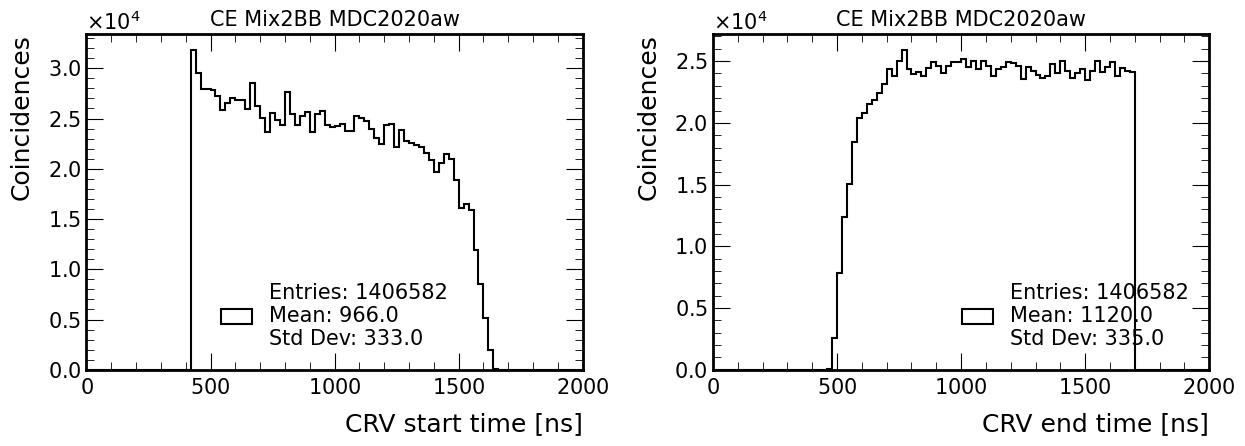

In [20]:
# Apply cut 

fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 1*4.8))


plotter.plot_1D(
    df_ce_mix["timeStart"],
    nbins=100,  
    xmin=0,
    xmax=2000,
    show=False,
    ax=ax[0],
    title="CE Mix2BB MDC2020aw",
    xlabel="CRV start time [ns]", 
    ylabel="Coincidences",
)

plotter.plot_1D(
    df_ce_mix["timeEnd"],
    nbins=100,  
    xmin=0,
    xmax=2000,
    show=False,
    ax=ax[1],
    title="CE Mix2BB MDC2020aw",
    xlabel="CRV end time [ns]", 
    ylabel="Coincidences",
)

plt.tight_layout()

out_name = img_base_path / "h1o_1x2_start_end_time_cut_verify.png" 
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()

## Scan dT

In [21]:
# Use ALL coincidences (no selection)
print(f"Using all coincidences:")
print(f"CRY: {len(df_cry):,} coincidences")
print(f"Mix2BB: {len(df_ce_mix):,} coincidences")
print(f"\nWill check if event is vetoed = has ANY coincidence in timing window")

Using all coincidences:
CRY: 23,145 coincidences
Mix2BB: 1,406,582 coincidences

Will check if event is vetoed = has ANY coincidence in timing window


In [22]:
def apply_dt_cut(df, dt_min, dt_max):
    """
    Apply dT timing window cut on event level.
    
    Fraction of events that pass
    """
    # Find rows where dT is within the window
    in_window = (df['dT'] >= dt_min) & (df['dT'] <= dt_max)
    
    # Get unique (event, subrun) pairs that have at least one dT in window
    pass_events = set(zip(df.loc[in_window, 'event'], df.loc[in_window, 'subrun']))
    
    # Get total unique events
    total_events = set(zip(df['event'], df['subrun']))
    
    # Calculate efficiency
    efficiency = len(pass_events) / len(total_events) if len(total_events) > 0 else 0
    
    return pass_events, efficiency

# Test the function
dt_min, dt_max = -25, 150
pass_events_cry, eff_cry = apply_dt_cut(df_cry, dt_min, dt_max)
pass_events_mix, eff_mix = apply_dt_cut(df_ce_mix, dt_min, dt_max)

print(f"dT window: [{dt_min}, {dt_max}] ns")
print(f"\nCRY:")
print(f"  Total events: {len(set(zip(df_cry['event'], df_cry['subrun']))):,}")
print(f"  Events passing: {len(pass_events_cry):,}")
print(f"  Efficiency: {eff_cry*100:.2f}%")

print(f"\nCE Mix2BB:")
print(f"  Total events: {len(set(zip(df_ce_mix['event'], df_ce_mix['subrun']))):,}")
print(f"  Events passing: {len(pass_events_mix):,}")
print(f"  Efficiency: {eff_mix*100:.2f}%")

# 99.980081
# 1	After cut	13782	13777	5	99.963721

dT window: [-25, 150] ns

CRY:
  Total events: 19,641
  Events passing: 19,637
  Efficiency: 99.98%

CE Mix2BB:
  Total events: 403,809
  Events passing: 149,941
  Efficiency: 37.13%


In [ ]:
# Scan timing window ranges
print("Scanning timing windows...")

# Define ranges to scan
lower_bounds = np.arange(-50, 15, 5) 
upper_bounds = np.arange(100, 205, 5) 

results = []
for dt_min in lower_bounds:
    for dt_max in upper_bounds:
        if dt_max <= dt_min:
            continue
        
        # Check if event is vetoed = has ANY coincidence in window
        # For CRY: want to veto (catch cosmics)
        cry_in_window = (df_cry['dT'] >= dt_min) & (df_cry['dT'] <= dt_max)
        cry_vetoed_events = df_cry[cry_in_window].groupby(['event', 'subrun']).size()
        cry_total_events = df_cry.groupby(['event', 'subrun']).size()
        eff_cry = len(cry_vetoed_events) / len(cry_total_events)
        
        # For CE Mix2BB: deadtime (fraction of events incorrectly vetoed)
        mix_in_window = (df_ce_mix['dT'] >= dt_min) & (df_ce_mix['dT'] <= dt_max)
        mix_vetoed_events = df_ce_mix[mix_in_window].groupby(['event', 'subrun']).size()
        mix_total_events = df_ce_mix.groupby(['event', 'subrun']).size()
        eff_mix = len(mix_vetoed_events) / len(mix_total_events)
        
        results.append({
            'dt_min': dt_min,
            'dt_max': dt_max,
            'width': dt_max - dt_min,
            'eff_cry': eff_cry * 100,
            'eff_mix': eff_mix * 100,
        })

df_scan = pd.DataFrame(results)
print(f"Scanned {len(df_scan)} window combinations")

# Find the minimum window width at 99.9% efficiency
df_99p9 = df_scan[df_scan['eff_cry'] >= 99.9].copy()
df_99p9['width'] = df_99p9['dt_max'] - df_99p9['dt_min']
min_width_idx = df_99p9['width'].idxmin()
optimal = df_99p9.loc[min_width_idx]
print(f"\nMinimum window at 99.9% CRY efficiency:")
print(f"  dt_min={optimal['dt_min']:.0f} ns, dt_max={optimal['dt_max']:.0f} ns")
print(f"  Width: {optimal['width']:.0f} ns")
print(f"  CRY efficiency: {optimal['eff_cry']:.2f}%")
print(f"  CE Mix2BB deadtime: {optimal['eff_mix']:.2f}%")

# Get baseline values
baseline = df_scan[(df_scan['dt_min'] == -25) & (df_scan['dt_max'] == 150)].iloc[0]

Scanning timing windows...
Scanned 273 window combinations

Minimum window at 99.9% CRY efficiency:
  dt_min=5 ns, dt_max=115 ns
  Width: 110 ns
  CRY efficiency: 99.91%
  CE Mix2BB deadtime: 26.06%


	Wrote ../../output/images/dt/b/h2_1x2_dt_eff_deadtime.png


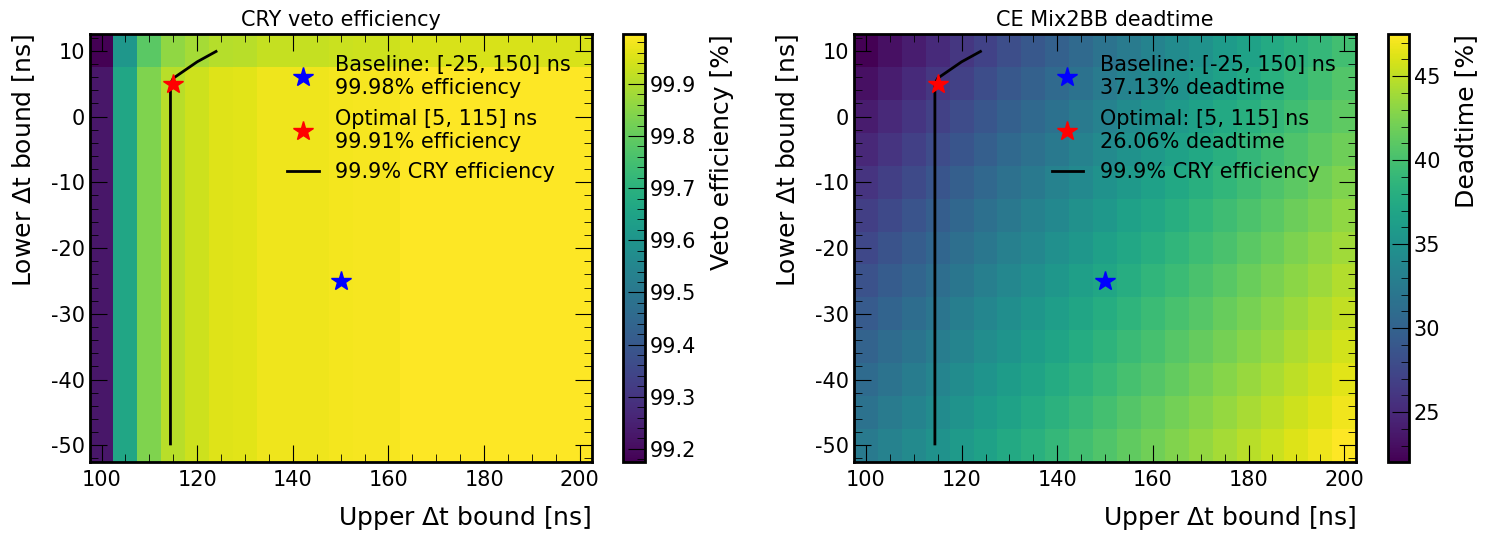

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(1.2*6.4*2, 1.2*4.8))

# CRY veto efficiency
pivot_cry = df_scan.pivot(index='dt_min', columns='dt_max', values='eff_cry')
im1 = axes[0].pcolormesh(pivot_cry.columns, pivot_cry.index, pivot_cry.values, cmap='viridis')
contour_cry = axes[0].contour(pivot_cry.columns, pivot_cry.index, pivot_cry.values, levels=[99.9], colors='black', linewidths=2)
axes[0].set_xlabel(r'Upper $\Delta t$ bound [ns]')
axes[0].set_ylabel(r'Lower $\Delta t$ bound [ns]')
axes[0].set_title('CRY veto efficiency')
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Veto efficiency [%]')
axes[0].plot(150, -25, marker='*', color="blue", markersize=15, linestyle='none', label=f'Baseline: [-25, 150] ns\n{baseline["eff_cry"]:.2f}% efficiency')
axes[0].plot(optimal['dt_max'], optimal['dt_min'], marker='*', color='red', markersize=15, linestyle='none', label=f'Optimal [{optimal["dt_min"]:.0f}, {optimal["dt_max"]:.0f}] ns\n{optimal["eff_cry"]:.2f}% efficiency')
axes[0].plot([], [], 'k-', linewidth=2, label='99.9% CRY efficiency')
axes[0].legend(loc="best")


# CE Mix2BB deadtime
pivot_mix = df_scan.pivot(index='dt_min', columns='dt_max', values='eff_mix')
im2 = axes[1].pcolormesh(pivot_mix.columns, pivot_mix.index, pivot_mix.values, cmap='viridis')
contour_mix = axes[1].contour(pivot_cry.columns, pivot_cry.index, pivot_cry.values, levels=[99.9], colors='black', linewidths=2)
axes[1].set_xlabel(r'Upper $\Delta t$ bound [ns]')
axes[1].set_ylabel(r'Lower $\Delta t$ bound [ns]')
axes[1].set_title('CE Mix2BB deadtime')
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Deadtime [%]')
axes[1].plot(150, -25, marker='*', color="blue", markersize=15, linestyle='none', label=f'Baseline: [-25, 150] ns\n{baseline["eff_mix"]:.2f}% deadtime')
axes[1].plot(optimal['dt_max'], optimal['dt_min'], marker='*', color='red', markersize=15, linestyle='none', label=f'Optimal: [{optimal["dt_min"]:.0f}, {optimal["dt_max"]:.0f}] ns\n{optimal["eff_mix"]:.2f}% deadtime')
axes[1].plot([], [], 'k-', linewidth=2, label='99.9% CRY efficiency')
axes[1].legend(loc="best")

plt.tight_layout()

img_base_path = Path(f"../../output/images/dt/{run}")
img_base_path.mkdir(exist_ok=True, parents=True)
out_name = img_base_path / "h2_1x2_dt_eff_deadtime.png" 
plt.savefig(out_name, dpi=300)
print(f"\tWrote {out_name}")
plt.show()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../output/images/dt/b/h1_1x2_dT.png


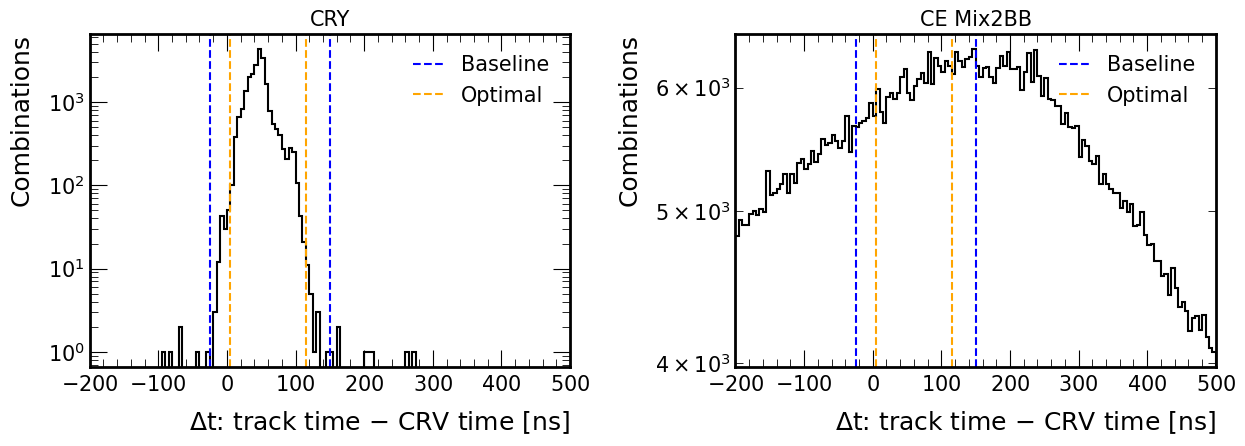

In [25]:
plotter = Plot()

fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 1*4.8))

# CRY distribution
plotter.plot_1D( 
    df_cry['dT'].values,
    nbins=140,
    xmin=-200, 
    xmax=500,
    title=r"CRY",
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel=r"Combinations",
    show=False,
    col="black",
    ax=ax[0],
    log_y=True
)

# CE Mix2BB distribution
plotter.plot_1D( 
    df_ce_mix['dT'].values,
    nbins=140,
    xmin=-200, 
    xmax=500,
    title=r"CE Mix2BB",
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel=r"Combinations",
    show=False,
    col="black",
    ax=ax[1],
    log_y=True
)

for i_ax, subplot in enumerate(ax):
    # Baseline
    subplot.axvline(-25, linestyle="--", color="blue", label="Baseline")
    subplot.axvline(150, linestyle="--", color="blue")
    # Optimal
    subplot.axvline(optimal['dt_min'], linestyle="--", color="orange", label="Optimal")
    subplot.axvline(optimal['dt_max'], linestyle="--", color="orange")
    subplot.legend()

plt.tight_layout()
out_name = img_base_path / "h1_1x2_dT.png"
plt.savefig(out_name, dpi=300)

print(f"\tWrote {out_name}")
plt.show()


In [83]:
def get_cent_dT(df, dt_min=-25, dt_max=150, tag=""):
    """
    Get the dT value closest to the window center for each event.
    """
    window_center = (dt_min + dt_max) / 2
    df = df.copy(deep=True)  # Avoid modifying original dataframe
    df['dist_to_centre'] = np.abs(df['dT'] - window_center)
    
    # Get the central dT for each event
    central_dt_per_event = df.loc[df.groupby(['event', 'subrun'])['dist_to_centre'].idxmin()][['event', 'subrun', 'dT']]
    central_dt_per_event = central_dt_per_event.rename(columns={'dT': f'cent_dT{tag}'})
    
    # Merge back to add as column
    df = df.merge(central_dt_per_event, on=['event', 'subrun'], how='left')
    df = df.drop(columns=['dist_to_centre'])
    
    return df

df_cry = get_cent_dT(df_cry, dt_min=5, dt_max=115, tag="_opt")
df_ce_mix = get_cent_dT(df_ce_mix, dt_min=5, dt_max=115, tag="_opt")

In [86]:
# df_cry.head()
print("different?", (df_cry['cent_dT'] != df_cry['cent_dT_opt']).any())
print("how many?", (df_cry['cent_dT'] != df_cry['cent_dT_opt']).sum(), "out of", df_cry['cent_dT'].sum())

different? True
how many? 147 out of 1130009.0505619156


[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../output/images/dt/b/h1_dT_centdT_overlay.png


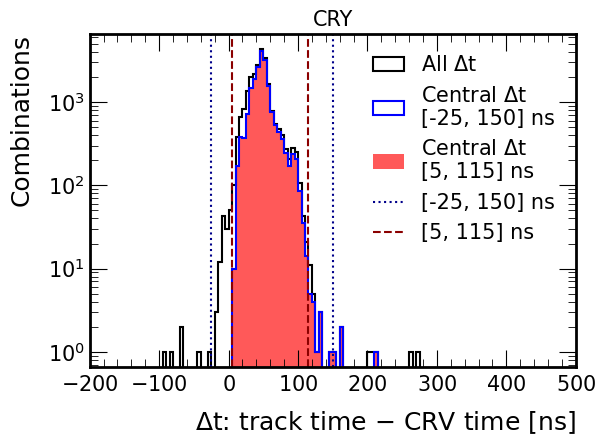

In [127]:
plotter = Plot()

# # Get central dT for CRY (one per event - closest to window center)
# window_center = (optimal['dt_min'] + optimal['dt_max']) / 2
# df_cry['dist_to_center'] = np.abs(df_cry['dT'] - window_center)
# central_dt_cry = df_cry.loc[df_cry.groupby(['event', 'subrun'])['dist_to_center'].idxmin()]['dT'].values

fig, ax = plt.subplots() # 1,2, figsize=(2*6.4, 4.8)) 



styles = {
    "All $\Delta t$": {
        "color": "black",
        "histtype": "step",
        "linewidth": 1.5,
    },
    "Central $\Delta t$\n[-25, 150] ns": {
        "color": "blue",
        #"alpha": 0.5,
        "histtype": "step",
        "linewidth": 1.5
    
    },
    "Central $\Delta t$\n[5, 115] ns": {
        "color": "red",
        "alpha": 0.65,
        "histtype": "stepfilled"
    }
}
# CRY: overlay all dT and central dT
plotter.plot_1D_overlay(
    {
        "All $\Delta t$": df_cry['dT'].values,
        "Central $\Delta t$\n[-25, 150] ns": df_cry.drop_duplicates(subset=['event', 'subrun'])["cent_dT"].values,
        "Central $\Delta t$\n[5, 115] ns": df_cry.drop_duplicates(subset=['event', 'subrun'])["cent_dT_opt"].values
    },
    nbins=140,
    xmin=-200, 
    xmax=500,
    title=r"CRY",
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel=r"Combinations",
    show=False,
    ax=ax,
    log_y=True,
    styles=styles
)




# # Baseline
# for i_ax in ax:
#     i_ax.axvline(-25, linestyle="--", color="blue", label="Baseline")
#     i_ax.axvline(150, linestyle="--", color="blue")
#     # Optimal
#     i_ax.axvline(optimal['dt_min'], linestyle="--", color="orange", label="Optimal")
#     i_ax.axvline(optimal['dt_max'], linestyle="--", color="orange")
#     i_ax.legend()

ax.axvline(-25, linestyle=":", linewidth=1.5, color="darkblue", label="[-25, 150] ns")
ax.axvline(150, linestyle=":", linewidth=1.5, color="darkblue")
# Optimal
ax.axvline(optimal['dt_min'], linestyle="--", linewidth=1.5, color="darkred", label="[5, 115] ns")
ax.axvline(optimal['dt_max'], linestyle="--", linewidth=1.5, color="darkred")
ax.legend()
plt.tight_layout()
out_name = img_base_path / "h1_dT_centdT_overlay.png"
plt.savefig(out_name, dpi=300)
print(f"\tWrote {out_name}")
plt.show()


## Find events between -25 and 0 ns in all combinations

## Filter events with dT in [-25, 0] range

Create a DataFrame per unique event that contains all dTs for events where at least one dT falls in the range [-25, 0].

In [29]:
# Filter events that have at least one dT in the range [-25, 0]
# Work with the DataFrame (df_cry) which has event, subrun, dT columns

# Find (event, subrun) pairs that have at least one dT in the target range
dt_in_range_mask = (df_cry['dT'] < 0) & (df_cry['dT'] > -25)
events_with_target_dt = df_cry.loc[dt_in_range_mask, ['event', 'subrun']].drop_duplicates()

# Merge back to get all rows for those events (all dTs for each qualifying event)
df_filtered = df_cry.merge(events_with_target_dt, on=['event', 'subrun'], how='inner')

print(f"Original coincidences: {len(df_cry):,}")
print(f"Unique events in original: {df_cry.groupby(['event', 'subrun']).ngroups:,}")
print(f"\nEvents with at least one dT in [-25, 0]: {len(events_with_target_dt):,}")
print(f"Total coincidences for filtered events: {len(df_filtered):,}")

Original coincidences: 23,145
Unique events in original: 19,641

Events with at least one dT in [-25, 0]: 88
Total coincidences for filtered events: 183


In [128]:
# Create a DataFrame with one row per event, containing all dTs as an array
df_events = df_filtered.groupby(['event', 'subrun'])['dT'].apply(list).reset_index()
df_events.columns = ['event', 'subrun', 'dT_array']

print(f"DataFrame with {len(df_events)} events")
print(df_events.head(10))

out_name = results_base_path / "filtered_events_dT.csv"
df_events.to_csv(out_name, index=False)

print(f"Wrote {out_name}")

DataFrame with 88 events
     event   subrun                                           dT_array
0   4117.0  80884.0           [11.510548856916785, -8.214670869645715]
1  20836.0  17268.0            [9.357603993558541, -8.716004404878959]
2  28102.0  37133.0           [13.778081191182764, -7.575373398660986]
3  30313.0  48093.0          [-10.697883886910404, 17.287467675589596]
4  38307.0  62391.0            [16.89957069669549, -7.041591412679509]
5  46504.0  52461.0  [54.466524170543266, -15.954374266956734, 11.1...
6  49017.0  28882.0           [-11.383291594609773, 9.369760163202727]
7  50015.0  41264.0           [-2.1776541468939286, 25.56050503279357]
8  56175.0  30541.0            [-11.47414118451752, 16.63071721391998]
9  64533.0  39850.0           [-5.954539643689486, 19.671558989123014]
Wrote ../../output/dt/b/results/filtered_events_dT.csv


In [153]:
sample = df_events.sample(n=10).round(1)
display(sample, random_state=3)
out_name = results_base_path / "filtered_events_dT_sample.csv"
sample.to_csv(out_name, index=False)

print(f"Wrote {out_name}")

,event,subrun,dT_array
13,72302.0,74403.0,"[28.38303937315277, -2.3444386541909807, 33.97..."
77,417896.0,17840.0,"[-6.255326101201035, 13.552901437861465]"
9,64533.0,39850.0,"[-5.954539643689486, 19.671558989123014]"
11,70725.0,29803.0,"[-3.159942576018352, 19.625457814606648]"
22,96602.0,30522.0,"[-4.855461149449866, 21.229621858362634]"
36,198400.0,37196.0,"[-9.034912351568437, 20.343627687494063]"
34,167587.0,21408.0,"[9.710564215667773, -8.580024163238477]"
62,320160.0,45313.0,"[-5.387041080979998, 17.603193294020002]"
38,211545.0,5132.0,"[-0.17998847604621915, 30.54938164114128]"
14,73593.0,25324.0,"[10.361715955432373, -7.3998807242551266]"


Wrote ../../output/dt/b/results/filtered_events_dT_sample.csv


Total coincidences: 23,145
Unique events: 19,641

Coincidences per event statistics:
count    19641.000000
mean         1.178402
std          0.412192
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: n_coincidences, dtype: float64

Wrote ../../output/images/dt/b/h2_dT_vs_n_coincidences.png


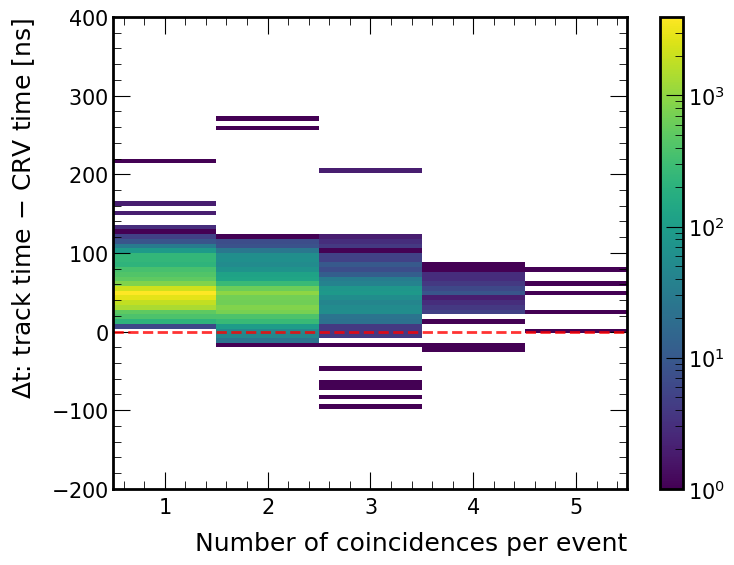

In [142]:
df_cry_with_count = df_cry.copy()
coincidence_counts = df_cry_with_count.groupby(['event',
'subrun']).size().reset_index(name='n_coincidences')
df_cry_with_count = df_cry_with_count.merge(coincidence_counts,
on=['event', 'subrun'], how='left')

print(f"Total coincidences: {len(df_cry_with_count):,}")
print(f"Unique events: {df_cry_with_count.groupby(['event', 
'subrun']).ngroups:,}")
print(f"\nCoincidences per event statistics:")
print(coincidence_counts['n_coincidences'].describe())

# Create 2D plot of dT vs number of coincidences
fig, ax = plt.subplots(figsize=(8, 6))

plotter.plot_2D(
    df_cry_with_count['n_coincidences'].values,
    df_cry_with_count['dT'].values,
    nbins_x=5,
    nbins_y=100,
    xmin=0.5,
    xmax=5.5,
    ymin=-200,
    ymax=400,
    xlabel="Number of coincidences per event",
    ylabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    # title="CRY: All $\Delta t$ vs coincidence multiplicity",
    show=False,
    ax=ax,
    log_z=True,
    cmap="viridis"
)

# Add window boundaries
# ax.axhline(-25, linestyle=":", linewidth=1.5, color="cyan", label="[-25, 150] ns", alpha=0.8)


ax.axhline(0, linestyle="--", linewidth=2, color="red", alpha=0.8)
# ax.axhline(optimal['dt_min'], linestyle="--", linewidth=1.5,
# color="yellow", label="[5, 115] ns", alpha=0.8)
# ax.axhline(optimal['dt_max'], linestyle="--", linewidth=1.5,
# color="yellow", alpha=0.8)
# ax.legend(loc='upper right')

plt.tight_layout()
out_name = img_base_path / "h2_dT_vs_n_coincidences.png"
plt.savefig(out_name, dpi=300)
print(f"\nWrote {out_name}")
plt.show()

## Analyse sectors 

In [33]:
# Check what sectorType values we have
print("Unique sectorType values in CRY data:")
print(sorted(df_cry['sector'].unique()))
print(f"\nValue counts:")
print(df_cry['sector'].value_counts().sort_index())

Unique sectorType values in CRY data:
[np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(9.0)]

Value counts:
sector
1.0     4525
2.0     2089
3.0    16436
4.0       60
5.0        4
6.0        5
9.0       26
Name: count, dtype: int64


In [48]:
# Add sectorType column based on sector mapping
sector_type_map = {
    1.0: 'R',  # Right
    2.0: 'L',  # Left
    3.0: 'T',  # Top
    4.0: 'E',  # Extraction/end
    5.0: 'U',  # Upstream
    6.0: 'D',  # Downstream
    7.0: 'C',  # Cryo
    # 9.0: 'Unknown'  # Unknown
}

df_cry['sectorType'] = df_cry['sector'].map(sector_type_map)
df_ce_mix['sectorType'] = df_ce_mix['sector'].map(sector_type_map)

# Check distribution
print("CRY sectorType distribution:")
print(df_cry['sectorType'].value_counts().sort_index())
print(f"\nTotal CRY coincidences: {len(df_cry):,}")

CRY sectorType distribution:
sectorType
D        5
E       60
L     2089
R     4525
T    16436
U        4
Name: count, dtype: int64

Total CRY coincidences: 23,145


In [49]:
df_cry.columns

Index(['event', 'subrun', 'run', 'dT', 'crv_x', 'crv_y', 'crv_z', 'PEs',
       'nHits', 'nLayers', 'angle', 'timeStart', 'timeEnd', 'crv_time',
       'sector', 'PEs_per_hit', 't0', 'd0', 'tanDip', 'maxr', 'mom_mag',
       'duration', 'cent_dt', 'sectorType', 'dist_to_center'],
      dtype='object')

In [50]:
# Calculate mean dT by sectorType
# For all combinations
mean_by_sector_all = df_cry.groupby('sectorType')['dT'].agg(['mean', 'std', 'count']).sort_index()
mean_by_sector_all.columns = ['mean_dT_all', 'std_dT_all', 'n_combinations']

# For central dT (one per event)
# Get central dT for each event
window_center = (optimal['dt_min'] + optimal['dt_max']) / 2
df_cry['dist_to_center'] = np.abs(df_cry['dT'] - window_center)

# Get one central dT per event with its sectorType
central_df = df_cry.loc[df_cry.groupby(['event', 'subrun'])['dist_to_center'].idxmin()][['event', 'subrun', 'dT', 'sectorType']]
mean_by_sector_central = central_df.groupby('sectorType')['dT'].agg(['mean', 'std', 'count']).sort_index()
mean_by_sector_central.columns = ['mean_dT_central', 'std_dT_central', 'n_events']

# Combine results
summary_by_sector = pd.concat([mean_by_sector_all, mean_by_sector_central], axis=1)
print("Mean dT by sectorType:")
print("="*80)
display(summary_by_sector)

out_name = results_base_path / "dT_summary_by_sector.csv"
summary_by_sector.to_csv(out_name, index=False)

print(f"Wrote {out_name}")

Mean dT by sectorType:


,mean_dT_all,std_dT_all,n_combinations,mean_dT_central,std_dT_central,n_events
sectorType,,,,,,
D,35.871732,81.289327,5,123.407244,NaN,1
E,64.676800,5.935152,60,64.375903,3.978455,48
L,38.991726,18.118874,2089,47.408061,11.622832,1002
R,39.765102,19.511319,4525,48.285925,15.081764,2508
T,49.151528,16.851316,16436,48.797651,16.223005,16072
U,78.317326,86.678140,4,28.724017,NaN,1


Wrote ../../output/dt/b/results/dT_summary_by_sector.csv


[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../output/images/dt/b/h1o_1x2_dT_by_sectorType.png


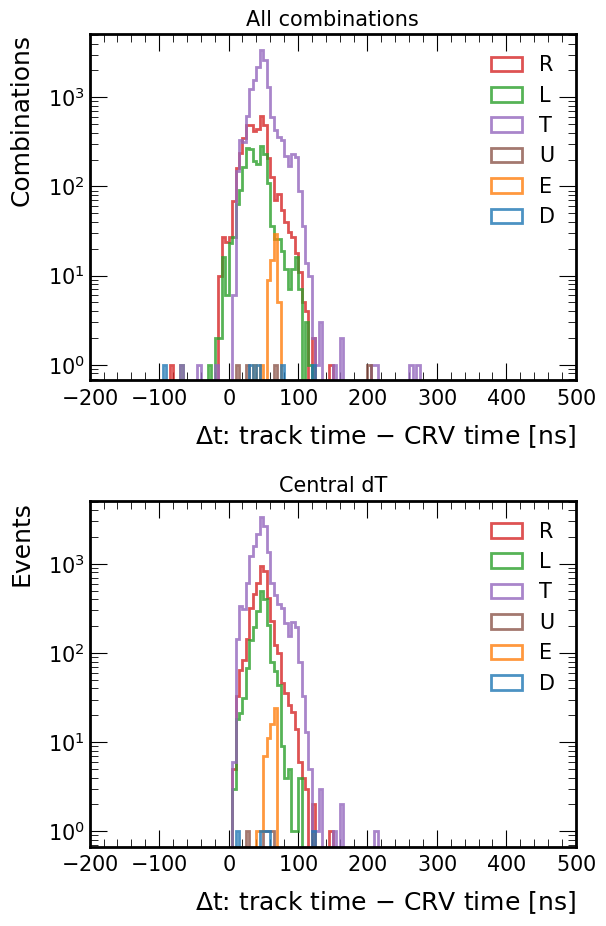

In [154]:
# Create histograms by sectorType
plotter = Plot()

# Get all unique sector types
major_sectors = df_cry['sectorType'].unique()

# Define colors for each sector type
sector_colors = {
    'D': '#1f77b4',  # Blue
    'E': '#ff7f0e',  # Orange
    'L': '#2ca02c',  # Green
    'R': '#d62728',  # Red
    'T': '#9467bd',  # Purple
    'U': '#8c564b',  # Brown
    # 'Unknown': '#7f7f7f',  # Gray
}

def prepare_sector_data(df, sectors, column='dT'):
    """Prepare data and styles dictionaries for sector plotting."""
    data = {}
    styles = {}
    for sector in sectors:
        sector_data = df[df['sectorType'] == sector][column].values
        if len(sector_data) > 0:
            data[sector] = sector_data
            styles[sector] = {
                'color': sector_colors.get(sector, 'black'),
                'histtype': 'step',
                'linewidth': 2,
                'alpha': 0.8
            }
    return data, styles

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(6.4, 2*4.8))

# Plot 1: All combinations
data_all, styles_all = prepare_sector_data(df_cry, major_sectors, column='dT')
plotter.plot_1D_overlay(
    data_all,
    nbins=140, xmin=-200, xmax=500,
    title="All combinations",
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel="Combinations",
    show=False, ax=ax[0], log_y=True,
    styles=styles_all
)

# Plot 2: Central dT per event
data_central, styles_central = prepare_sector_data(df_cry, major_sectors, column='cent_dT_opt')
plotter.plot_1D_overlay(
    data_central,
    nbins=140, xmin=-200, xmax=500,
    title="Central dT",
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel="Events",
    show=False, ax=ax[1], log_y=True,
    styles=styles_central
)

plt.tight_layout()
out_name = img_base_path / "h1o_1x2_dT_by_sectorType.png"
plt.savefig(out_name, dpi=300)
print(f"\tWrote {out_name}")
plt.show()

	Wrote ../../output/images/dt/b/scatter_3d_sectors_spatial.png


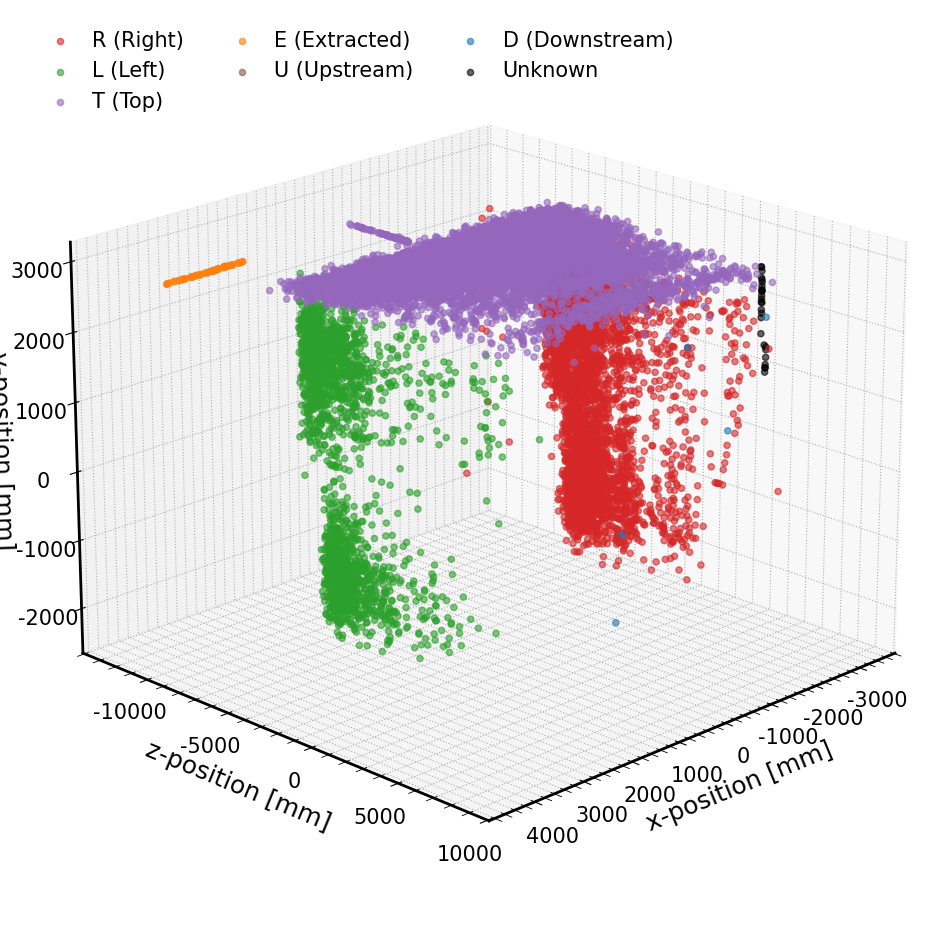

In [56]:
# Plot spatial distribution of all sectors in 3D
fig = plt.figure(figsize=(2*6.4, 2*4.8))
ax = fig.add_subplot(111, projection='3d')

# Color map for sectors
sector_colors_map = {
    1.0: '#d62728',  # R - Red
    2.0: '#2ca02c',  # L - Green
    3.0: '#9467bd',  # T - Purple
    4.0: '#ff7f0e',  # E - Orange
    5.0: '#8c564b',  # U - Brown
    6.0: '#1f77b4',  # D - Blue
    7.0: '#e377c2',  # C - Pink
    9.0: '#000000',  # Unknown - Black
}

sector_labels = {
    1.0: 'R (Right)',
    2.0: 'L (Left)',
    3.0: 'T (Top)',
    4.0: 'E (Extracted)',
    5.0: 'U (Upstream)',
    6.0: 'D (Downstream)',
    7.0: 'C (Cryo)',
    9.0: 'Unknown',
}

# Plot each sector (swap y and z so y is vertical)
for sector in sorted(df_cry['sector'].dropna().unique()):
    sector_data = df_cry[df_cry['sector'] == sector]
    color = sector_colors_map.get(sector, 'gray')
    label = sector_labels.get(sector, f'Sector {int(sector)}')
    
    ax.scatter(sector_data['crv_x'], sector_data['crv_z'], sector_data['crv_y'], 
               c=color, label=label, alpha=0.6, s=20)

# Formatting
ax.set_xlabel('x-position [mm]')
ax.set_ylabel('z-position [mm]')
ax.set_zlabel('y-position [mm]')
# ax.set_title('CRV Sectors') # , fontweight='bold')
ax.legend(loc='upper left', ncols=3)

# Set viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
out_name = img_base_path / "scatter_3d_sectors_spatial.png"
plt.savefig(out_name, dpi=300)
print(f"\tWrote {out_name}")
plt.show()